In [7]:
%load_ext autoreload
%autoreload 2

import torch

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from ml_rnn_names.model import CharRNN
from ml_rnn_names.processing import n_letters
from ml_rnn_names.training import train, set_seed
from ml_rnn_names.utils import torch_device_setup
from ml_rnn_names.data import load_data, collate_names

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using device = cpu
Loaded 18015 items of data
Train=11710, Val=3603, Test=2702
Trial 1/5: LR=0.2968, Hidden=64, Batch=32, Epochs=14
Training on data set with n = 11710
10 (71%): train_loss=0.7957, val_loss=0.8318, val_f1=0.3074
Training took 6.93s
Trial 2/5: LR=0.4986, Hidden=128, Batch=32, Epochs=5
Training on data set with n = 11710
Training took 3.08s
Trial 3/5: LR=0.0934, Hidden=64, Batch=32, Epochs=13
Training on data set with n = 11710
10 (77%): train_loss=0.8236, val_loss=0.8229, val_f1=0.2787
Training took 6.35s
Trial 4/5: LR=0.0363, Hidden=256, Batch=32, Epochs=6
Training on data set with n = 11710
Training took 6.28s
Trial 5/5: LR=0.4504, Hidden=256, Batch=64, Epochs=19
Training on data set with n = 11710
10 (53%): train_loss=0.8783, val_loss=0.9184, val_f1=0.2860
Training took 13.53s


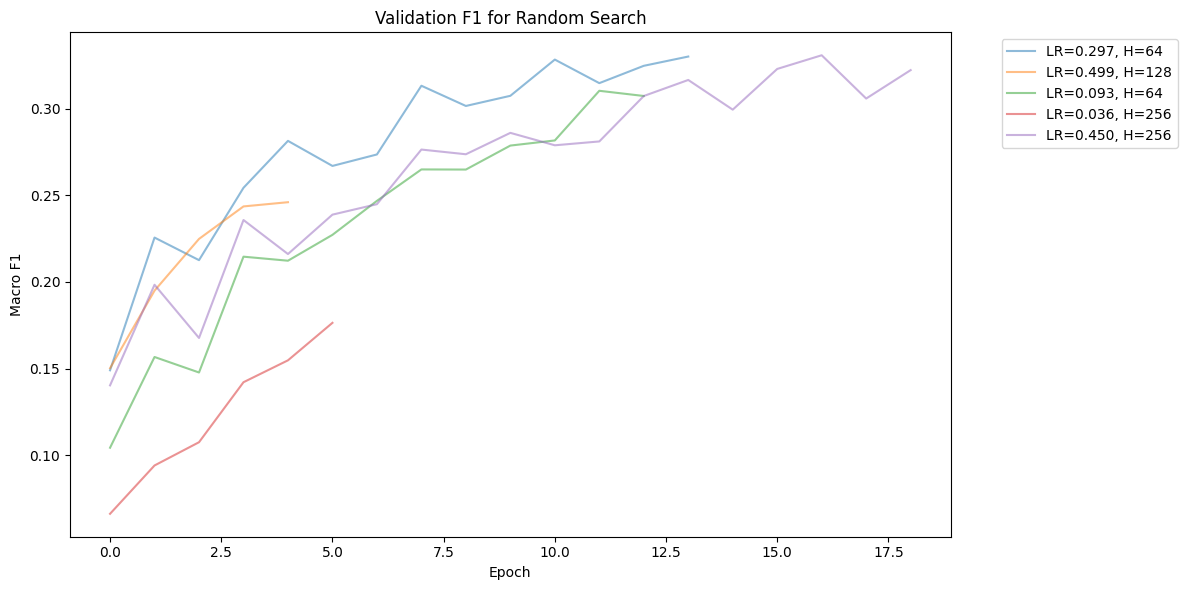


Best hyperparameters:
  learning_rate: 0.29682946449428416
  hidden_size: 64
  n_batch_size: 32
  n_epoch: 14
  final_f1: 0.3300661371770345


In [9]:
# Perform Random Search to find suitable hyperparameters
device = torch_device_setup()
train_set, val_set, test_set, labels_uniq = load_data(device, validation_split=0.2)

n_trials = 5  # Number of random combinations to try

param_ranges = {
    "hidden_size": [64, 128, 256, 512],  # discrete choices
    "learning_rate": (0.001, 0.5),  # (min, max) for uniform sampling
    "n_batch_size": [32, 64, 128],  # discrete choices
    "n_epoch": (5, 20),  # will be converted to int
}  # I removed "learning_rate" to try multiple below
fixed_model_parameters = {
    "input_size": n_letters,
    "output_size": len(labels_uniq),
}

results = []
plt.figure(figsize=(12, 6))

for trial in range(n_trials):
    set_seed(trial, device)
    # Randomly sample hyperparameters
    hidden_size = int(np.random.choice(param_ranges["hidden_size"]))
    learning_rate = np.random.uniform(*param_ranges["learning_rate"])
    n_batch_size = int(np.random.choice(param_ranges["n_batch_size"]))
    n_epoch = int(np.random.uniform(*param_ranges["n_epoch"]))

    model_parameters = {**fixed_model_parameters, "hidden_size": hidden_size}
    hyper_parameters = {
        "n_epoch": n_epoch,
        "n_batch_size": n_batch_size,
        "learning_rate": learning_rate,
    }

    print(
        f"Trial {trial + 1}/{n_trials}: LR={learning_rate:.4f}, "
        f"Hidden={hidden_size}, Batch={n_batch_size}, Epochs={n_epoch}"
    )

    rnn = CharRNN(**model_parameters)
    result = train(
        model=rnn,
        training_data=train_set,
        validation_data=val_set,
        **hyper_parameters,
        device=device,
    )
    val_f1s = result["val_f1s"]

    # Store results
    results.append(
        {
            "learning_rate": learning_rate,
            "hidden_size": hidden_size,
            "n_batch_size": n_batch_size,
            "n_epoch": n_epoch,
            "final_f1": val_f1s[-1],
            "val_f1s": val_f1s,
        }
    )

    plt.plot(val_f1s, alpha=0.5, label=f"LR={learning_rate:.3f}, H={hidden_size}")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Macro F1")
plt.title("Validation F1 for Random Search")
plt.tight_layout()
plt.show()

# Find best hyperparameters
best_trial = max(results, key=lambda x: x["final_f1"])
print("\nBest hyperparameters:")
for key, value in best_trial.items():
    if key != "val_f1s":
        print(f"  {key}: {value}")

Using device = cpu
Loaded 18015 items of data
Train=11710, Val=3603, Test=2702
Training on data set with n = 11710
10 (33%): train_loss=0.7895, val_loss=0.8663, val_f1=0.3107
20 (67%): train_loss=0.6920, val_loss=0.8340, val_f1=0.3541
30 (100%): train_loss=0.6784, val_loss=0.8884, val_f1=0.2936
Training took 12.20s


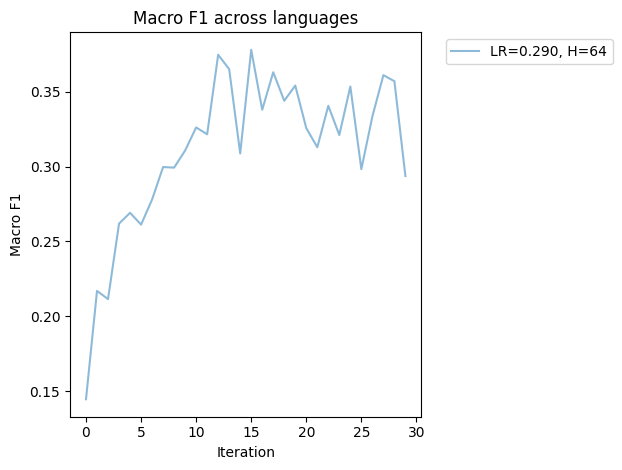

In [ ]:
device = torch_device_setup()
train_set, val_set, test_set, labels_uniq = load_data(device, 0.2)

model_parameters = {
    "input_size": n_letters,
    "output_size": len(labels_uniq),
    "hidden_size": 64,
}
hyper_parameters = {
    "n_epoch": 30,
    "n_batch_size": 32,
    "learning_rate": 0.15,
}

rnn = CharRNN(**model_parameters)
result = train(
    model=rnn,
    training_data=train_set,
    validation_data=val_set,
    **hyper_parameters,
    device=device,
)
val_f1s = result["val_f1s"]

plt.plot(
    val_f1s,
    alpha=0.5,
    label=f"LR={hyper_parameters['learning_rate']:.3f}, H={model_parameters['hidden_size']}",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("Iteration")
plt.ylabel("Macro F1")
plt.title("Macro F1 across languages")
plt.tight_layout()
plt.show()

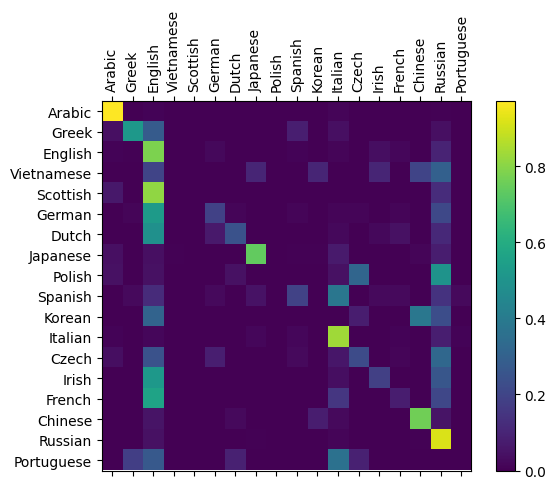

In [10]:
from torch.utils.data import DataLoader


def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    dataloader = DataLoader(
        testing_data,
        batch_size=64,
        shuffle=False,
        collate_fn=collate_names,
    )

    rnn.eval()
    with torch.no_grad():
        for labels, padded_texts, lengths in dataloader:
            outputs = rnn(padded_texts, lengths)
            _, predictions = outputs.topk(1)
            predictions = predictions.squeeze(1)

            for label, pred in zip(labels, predictions):
                confusion[label][pred] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


evaluate(rnn, test_set, classes=labels_uniq)